Download the files as instructed by dbGAP, decrypt them and decompress them.

In [56]:
# setup
import pandas as pd
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pandas.api.types import CategoricalDtype

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

plt.rcParams['axes.labelweight'] = 'bold'   
plt.rcParams['axes.labelsize'] = 14  
plt.rcParams.update(plt.rcParamsDefault) #essential to be able to use ARIAL
plt.rcParams['svg.fonttype'] = 'none' #essential to be able to modify text in svg figures
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14  
plt.rcParams['font.sans-serif'] = 'Arial' # this might not work if the font Arial is not installed 

font = {'size'   : 14}
plt.rc('font', **font)    
             


In [2]:
# update data directory

data_directory= '/directory/of/files/here' 

# Dataset preparation

In this section, the expression dataset is prepared.
1) Load the dataset
2) Decode the data to have subject ID as column headers of gene expression matrix
3) Select the gene of interest 
4) Merge gene expression data to the subjects phenotype info

### 1) Load the dataset

In [3]:
# Load tissue-specific gene expression file

tissue = 'muscle' # or 'adipose'
file = '/phe000033.v1.FUSION_TisssueBiopsy2_RNAseq.expression-data-matrixfmt.c1/phs001048.v2.p1.%s.gene.fpkm.txt' %tissue
expression_tissue = pd.read_csv('%s%s' %(data_directory, file), sep='\t')#, error_bad_lines=False)

### 2) Decode the data to have subject ID as column headers of gene expression matrix

In [10]:
# load decoding of sample and subject IDs
file = 'phe000033.v1.FUSION_TisssueBiopsy2_RNAseq.sample-info.MULTI.tar'
sample_data_expr = pd.read_csv('%s/%s' %(data_directory, file), sep='\t', error_bad_lines=False, skiprows=16, index_col=False)

# prepare decoding file
sample_data_expr.dropna(subset = ['Sample_ID', 'Subject_ID'], inplace= True)

#for some reason, assigning the type as str right now does not help. 
# Assigned it at first as int, then as str in the dictonary
sample_data_expr['Sample_ID'] =sample_data_expr['Sample_ID'].astype(int)
sample_data_expr['Subject_ID'] = sample_data_expr['Subject_ID'].astype(int)

# created a dictionary sample to subject
dictionary_sample_patient = {}

for i in sample_data_expr.itertuples():
    dictionary_sample_patient[str(i.Sample_ID)] = str(i.Subject_ID)


In [11]:
# Annotate the expression dataset to have subject ID as column name
expression_tissue.rename(columns = dictionary_sample_patient, inplace = True)

In [16]:
expression_tissue.head(1)

,gene,14799,14750,14805,14805,14794,14795,14710,17817,14801,...,29019,29048,29028,29047,29044,12726,14739,14744,14762,14793
0,ENSG00000000003.10,1.63894,3.60443,1.201395,1.034215,1.559002,2.506174,2.375858,0.675986,0.837131,...,0.65337,3.093456,1.249899,1.420618,1.887565,1.817393,1.545405,1.501664,2.08128,1.478274


### 3) Select the gene of interest

In [34]:
# Select gene of interest

gene_of_interest = 'ENSG00000134317.13'  # or whichever other gene of interest
gene_name= 'GRHL1'  # or whichever other gene of interest
gene = expression_tissue[expression_tissue['gene'].str.contains(gene_of_interest)]

In [37]:
# pivot table to have expression data of gene of interest and subject ID in columns

gene = gene.set_index('gene') 
gene = gene.T
gene['SUBJECT_ID'] = gene.index.astype(int)

### 4) Merge gene expression data to the subjects phenotype info

In [39]:
# load phenotype file
file = '%s/phs001048.v2.pht005660.v2.p1.c1.FUSION_Tissue_Biopsy_Subject_Phenotypes.GRU.txt.gz'%data_directory
phenotype = pd.read_csv('%s' %(file), sep='\t', error_bad_lines=False, skiprows=10)

b'Skipping line 318: expected 14 fields, saw 15\n'


In [40]:
phenotype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dbGaP_Subject_ID  306 non-null    int64  
 1   SUBJECT_ID        306 non-null    int64  
 2   sex               306 non-null    object 
 3   age_biopsy        306 non-null    int64  
 4   ogtt_status       306 non-null    object 
 5   GL0               306 non-null    float64
 6   S_Insu            306 non-null    float64
 7   bmi               306 non-null    float64
 8   whr               305 non-null    float64
 9   height            306 non-null    float64
 10  waist             305 non-null    float64
 11  weight            306 non-null    float64
 12  area_code         306 non-null    int64  
 13  smoke_current     306 non-null    int64  
dtypes: float64(7), int64(5), object(2)
memory usage: 33.6+ KB


In [55]:
# merge phenotype and gene expression data and prepare analysis columns

df =  pd.merge(phenotype, gene, on='SUBJECT_ID')

df['gene_log2'] = np.log2(df[gene_of_interest])
df['ogtt_status'] = pd.Categorical(df['ogtt_status'], categories = order, ordered = True)



In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 298
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dbGaP_Subject_ID    299 non-null    int64  
 1   SUBJECT_ID          299 non-null    int64  
 2   sex                 299 non-null    object 
 3   age_biopsy          299 non-null    int64  
 4   ogtt_status         299 non-null    object 
 5   GL0                 299 non-null    float64
 6   S_Insu              299 non-null    float64
 7   bmi                 299 non-null    float64
 8   whr                 298 non-null    float64
 9   height              299 non-null    float64
 10  waist               298 non-null    float64
 11  weight              299 non-null    float64
 12  area_code           299 non-null    int64  
 13  smoke_current       299 non-null    int64  
 14  ENSG00000134317.13  299 non-null    float64
 15  gene_log2           299 non-null    float64
dtypes: float

# Analysis

## Age distribution in FUSION subjects



Supplemental figure 5f

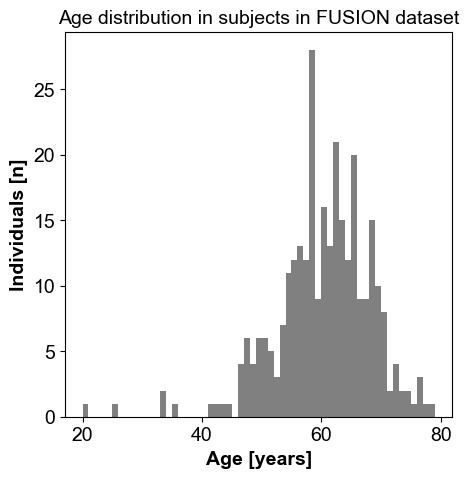

In [65]:
# Age distribution in FUSION subjects

fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel("Age [years]", fontsize=14,fontweight = 'bold')
plt.ylabel("Individuals [n]", fontsize=14,fontweight = 'bold')
plt.title('Age distribution in subjects in FUSION dataset',fontsize=14)

plt.hist(df['age_biopsy'], bins=59, color='Gray')

plt.xticks(fontsize=14, fontname = 'Arial')
plt.yticks(fontsize=14, fontname = 'Arial');
# plt.savefig('Fusion_histogram_Age.svg')


## Correlate oGTT status and GRHL1 expression
Results of figure 5k


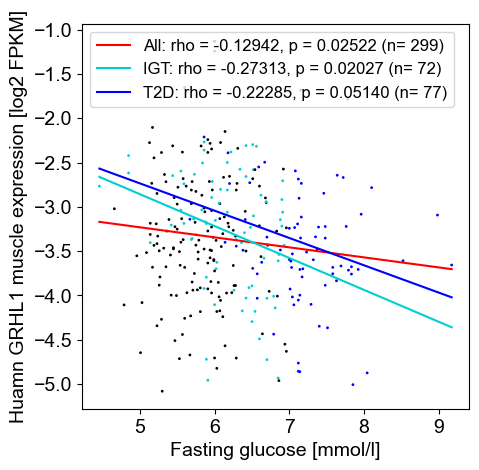

In [63]:
plt.figure(figsize=(5, 5))
colors_oGTT = {'NGT': 'black', 'IFG':'black', "IGT": 'darkturquoise', 'T2D':'blue' }


plt.scatter(df['GL0'], df[['gene_log2']], s=1, c=df['ogtt_status'].map(colors_oGTT))

correlation_array = np.array(df[[gene_of_interest,'GL0']])
p_r = stats.pearsonr(correlation_array[:,0], correlation_array[:,1])
s_r = stats.spearmanr(correlation_array[:,0], correlation_array[:,1])

m, b = np.polyfit(df['GL0'],  df['gene_log2'], 1) 
plt.plot(x, m*x + b, c='red', label="All: rho = %.5f, p = %.5f (n= %s)"%(s_r[0],s_r[1], len(df)) )



x = np.linspace(df['GL0'].min(), df['GL0'].max(), 1000)
for status in colors_oGTT:
    selected = df[df['ogtt_status'] == status]
    correlation_array = np.array(selected[[gene_of_interest,'GL0']])
    p_r = stats.pearsonr(correlation_array[:,0], correlation_array[:,1])
    s_r = stats.spearmanr(correlation_array[:,0], correlation_array[:,1])

    m, b = np.polyfit(selected['GL0'],  selected['gene_log2'], 1) 
    
#     plt.plot(x, m*x + b, c=colors_oGTT[status], label= status + " rho = %.f5" +str(  %s_r[0]) + " p = "+str(s_r[1]) )
    if (status == 'NGT') or (status == 'IFG'):
        pass
        
    else:
        plt.plot(x, m*x + b, c=colors_oGTT[status], label= status + ": rho = %.5f, p = %.5f (n= %s)"%(s_r[0],s_r[1], len(selected)) )


plt.legend(loc='upper left')    
plt.xlabel('Fasting glucose [mmol/l]')
plt.ylabel('Huamn %s %s expression [log2 FPKM]' %(gene_name, tissue))
plt.legend(loc= 'upper left',fontsize= 12)

# plt.savefig('Fusion_FastGluc_vs_GRHL1_expression_oGTTstatus.svg')